# <font color='blue'>ASTR 21100</font> 

# <font color='blue'>"Computational Techniques in Astrophysics"</font>

# <font color='blue'>Methods for sampling from 1-dimensional probability distributions</font>


In [1]:
import numpy as np 

# use jupyter "magic" command to tell it to embed plot into the notebook 
import matplotlib.pyplot as plt
%matplotlib inline

from codes.plotting import plot_prettier
plot_prettier()

### <font color='blue'>Sampling random numbers from a 1-dimensional probability distribution function (pdf)</font>

Such sampling involves two steps: 

1) a sequence of random, uniformly distributed numbers in the $[0,1]$ interval (this is handled by PRNG codes, see <a href="https://drive.google.com/file/d/1x3KUR8vqs-O7DDqJYUaT-0xA8x6Yh5oK/view?usp=sharing"><tt>08b_prngs.ipynb</tt></a>)

2) a transformation of that sequence from the uniform pdf to a desired (target) pdf.

### <font color='blue'>Definitions of the pdf and cdf</font>

* **Probability distribution function (pdf)** (sometimes called probability density function), $p(x)$, is a positive function, $p(x)\geq 0$, defined such that $p(x)dx$ measures probability for $x$ to be in the interval $[x,x+dx)$. 

If pdf is defined on an interval $x\in [a,b]$, integral over this interval for a properly normalized pdf is 

$$\int\limits_a^b p(x)dx=1$$

because probability of any $x$ should be 1 by definition. So pdf is always 0 or positive and normalized such that integral over the interval for which it is defined is equal to 1.


* **Cumulative distribution function (cdf)** is defined as 

$$P(x) = \int\limits_b^x p(x^\prime) dx^\prime.$$
If $p(x)\geq 0$ and is normalized as above, it is clear that $P$ varies monotonically from $0$ to $1$, as $x$ increases from the lower to the upper limits of the interval on which $p(x)$ is defined. 

**Note 1.** Whether pdf must be so normalized depends on its application. If we need only ratios such as $p(x_2)/p(x_1)$ then normalization is not relevant. Thus, for certain methods, such as MCMC normalization is not important.  

**Note 2.** Given that $p(x)dx$ is probability, which is dimensionless, if $x$ has some dimension (for example, grams), then $p(x)$ also must have dimension of $[x^{-1}]$ (i.e., inverse grams) so that product of $p(x)$ and $dx$ is dimensionless. Remembering that pdf has dimensions inverse of the dimension of its parameter is useful when algebraic operations with pdfs are performed, as we will see later. 

### <font color='blue'>Random sampling from pdfs</font>

The two simplest and widely used methods to sample non-uniform 1-dimensional pdfs (or in some cases low-dimensional ones) -- the inverse transform sampling and rejection sampling -- were laid out on one page in a letter by John von Neumann to Stanislaw Ulam written on May 21, 1947. 

The latter was known previously in a different context (geometric estimates of probability), but it was von Neumann who re-invented rejection sampling and made it popular in the context of Monte Carlo methods. 

<p>
<center><img width=400 src="https://astro.uchicago.edu/~andrey/classes/a211/img/John_von_Neumann-LosAlamos.gif"></img></center>
</p>

<center><img width=600 src="https://astro.uchicago.edu/~andrey/classes/a211/img/von_neumann_letter1.png"></img></center>

The inverse transform sampling is the most useful method in practice and is discussed in detail below. Rejection method is conceptually simpler, but is not as useful due to its inefficiency in general cases, especially for pdfs with a wide range of values, such as exponential or power law pdfs. 

### <font color='blue'> Inverse transform sampling (ITS) method</font>

For a sample of $x_i$ values drawn from $p(x)$ pdf which has cdf $P(x)$, we expect that $y_i = P(x_i)$ are uniformly distributed in $y\in [0,1]$. 

This method uses this statement in the reverse order: if I have samples $y_i$ drawn from the uniform pdf defined in $y\in [0,1]$, then $x_i$ values defined by equation 

$$y_i=P(x_i)$$

will follow $p(x)$ pdf. That's all there is to this method. All we need to handle is how to solve this equation for $x_i$ values. 


### <font color='blue'>  Example of using the ITS method: sampling an exponential pdf</font>

Application of the method is pretty straightforward if the equation can be solved for $x_i$ explicitly. For example, consider exponential pdf $p(x) = Ae^{-\beta x}$ for $\beta>0$ and $x\in [0,\infty)$.

$A$ is normalization factor ensuring that $p(x)$ is pdf: 

$$A\int\limits_0^\infty e^{-\beta x}dx = 1; \ \ \ {\rm i.e.}\ \ \rightarrow\ \ A = \frac{1}{\int_0^\infty e^{-\beta x}dx} = [x\rightarrow\tilde{x}=-\beta x]=\frac{1}{-(1/\beta)\int_0^{-\infty} e^{\tilde{x}}d\tilde{x}}=\frac{\beta}{\int^0_{-\infty} e^{\tilde{x}}d\tilde{x}}=\beta$$


So our pdf is $p(x) = \beta\, e^{-\beta x}$ and its cdf is 

$$P(x) = \beta\,\int\limits_0^x e^{-\beta x}dx = [x\rightarrow\tilde{x}=-\beta x]=-{\beta\over\beta}\,\int\limits_0^{\tilde{x}} e^{\tilde{x}}d\tilde{x} = \int\limits^0_{\tilde{x}} e^{\tilde{x}}d\tilde{x} = 1- e^{-\beta x}$$

and we can simply solve for $x$ algebraically: 

$$x(P) = -\frac{1}{\beta}\,\ln[1-P]$$

Now all we need to do to draw $n$ random numbers from the exponential distribution $p(x)=\beta\,e^{-\beta x}$ is to: 

* generate $n$ samples $y_i$ uniformly distributed in $[0,1]$


* transform them into $x_i = -1/\beta\ln[1-y_i]$.


Note that $x_i = -1/\beta\ln[1-y_i]=-1/\beta\ln\,y_i$ because if $y_i$ is a number uniformly distributed in $[0,1]$, so is $1-y_i$. 

In [25]:
def exp_pdf(x, beta):
    """
    normalized exponential PDF p(x)= e^{-x\beta}\beta
    
    Parameters:
    -----------
    x: 1d numpy array of real numbers 
    beta: a real non-zero number
        
    Returns:
    --------
    a 1d numpy vector of real numbers equal to the PDF values at input x values
    """
    return np.exp(-x*beta) * beta


In [4]:
def invcdf_exp(y, beta):
    """
    analytic inverse of the exponential CDF
    """
    assert(beta != 0.)
    
    return -np.log(1.-y) / beta

nr = 1000000
# generate a vector of nr uniformly distributed numbers over [0.,1.]
yrnd = np.random.uniform(0., 1., nr)

beta = 3.0
xexp = invcdf_exp(yrnd, beta)

In [27]:
def plot_pdf(xr, plot_pdf=True, func=None, args=None,
             xlabel='$x$', ylabel='$p(x)$',  label='samples', 
             bins = 50, xlog=False, ylog=True, 
             xlims=[0.,30.], ylims=[1.e-6, 0.4], figsize=5):
    """
    a utility function to plot samples from a pdf as a histogram and compare
    the histogram to the analytical form of the pdf plotted as a line, if needed
    
    Parameters:
    -----------
    xr:           1d numpy array of float numbers: vector of samples
    plot_pdf:     boolean, determines whether to plot a line of the target pdf
                  if True, func needs to be supplied
    func:         Python function object: function that returns analytic pdf for a given vector xr
    args:         list of possible arguments to func, if any
    xlabel, ylabel: strings, labels for x and y axes
    label:        string, label for the samples histogram for the legend
    bins:         integer or string (e.g., 'auto'), passed on as bins parameter to Pylab's histogram function
    xlog, ylog:   boolean, determine whether x or y axis is to be plotted on logarithmic scale
    xlims, ylims: lists of 2 float elements defining plot limits for x and y axes
    figsize:      float, parameter controlling plot size 
    
    Returns:
    --------
    Nada
    """
    plt.figure(figsize=(figsize,figsize))
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    if xlog: plt.xscale('log') # plot y-values on a logarithmic scale
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    plt.xlim(xlims); plt.ylim(ylims) # set axis limits 

    # compute histogram values; 
    # density='True' normalizes histogram properly so it can be compared to pdf
    hist, bins, patches = plt.hist(xr, density='True', color='slateblue', bins=bins, label=label)
    # compute bin centers using numpy slicing 
    binc = 0.5*(bins[1:] + bins[:-1])
    if plot_pdf: 
        plt.plot(binc, func(binc, *args), lw=1.25, c='orangered', label='target pdf')
    plt.ylabel(r'$p(x)$') # label axis 
    plt.xlabel(r'$x$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

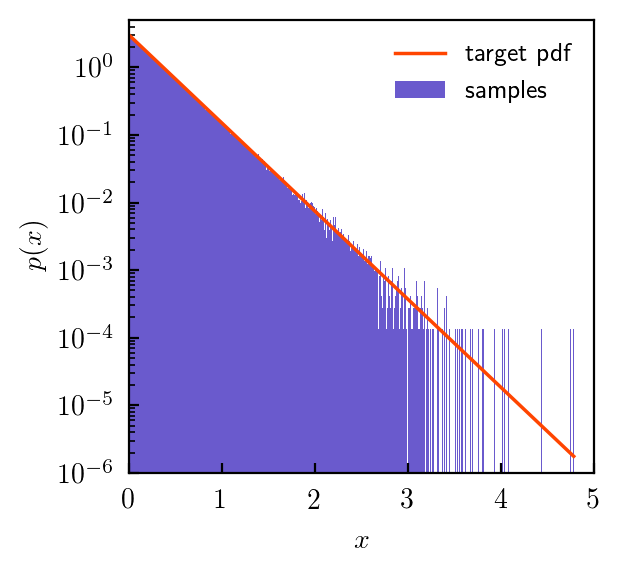

In [73]:
plot_pdf(xexp, func=exp_pdf, args=[beta], xlims=[0,5], ylims=[1.e-6,5], 
         bins='auto', xlabel=r'$x$', ylabel=r'$p(x)$', figsize=3)

### <font color='blue'>Why does the inverse transform method work? geometric interpretation</font>

The meaning of the method can be grasped by visualizing the cumulative pdf, $y=P(x)$ in the $x-y$ plane. Suppose we draw samples from the uniform distribution along $y$: i.e., $u_{[0,1]}=1$ for $y\in[0,1]$. The probability of a sample to fall within some interval $dy$ is $u_{[0,1]}dy=dy$ for $y\in [0,1]$. What will be the corresponding interval $dx$ along $x=P^{-1}(y)$ axis that corresponds to $dy$? 

Geometrically, $dx = dy/\tan\alpha= dy/(dP/dx) = dy/p(x)$, where $\alpha$ is the local slope of the cdf,  $\tan\alpha(x) = dP/dx=p(x)$, where the latter identity holds by the definition of cdf:

$$\frac{dP(x)}{dx} = \frac{d}{dx}\int\limits_{-\infty}^x p(x)dx = p(x)$$


Thus, uniform distribution of points in the vertical $y$ axis will turn into distribution of points in the horizonthal $x$ axis with density function $p(x)$, because $dy = p(x)dx$, which is precisely what we want.

### <font color='blue'>Why does the inverse transform method work? formal proof (read if you care)</font>


**Theorem.** if samples $x_i$ are drawn from pdf $p(x)$, the distribution of $P(x_i)$ will be uniform in the range $[0,1]$.

**Proof.**  Let's examine what kind of transformation $y(x)$ will convert these numbers into uniformly distributed  $y_i=y(x_i)$ in the interval $[0,1]$  


We know that pdfs are transformed using "conservation of probability equation": 

$$p(x)dx = g(y)dy,$$ 

so for a given transformation $y(x)$, the pdf of $y$ will be 

$$g(y) = p(x)\, {dx\over dy} = {p(x)\over y^\prime},$$ 

where $y^\prime=dy/dx$ is derivative of $y(x)$ wrt $x$. 

Thus, if $y^\prime = p(x)$, then $g(y)=1$, which is a uniform pdf in the interval $y\in[0,1]$. 

However, the function derivative of which wrt $x$ is $p(x)$ is its cdf $P(x)$ by definition: 

$$\frac{dP(x)}{dx} = \frac{d}{dx}\int\limits_{-\infty}^x p(x)dx = p(x),\ \ \ {\rm and\ thus}\ \rightarrow\ y(x)=P(x).$$

Thus, this result tells thus that for $x_i$ drawn from pdf $p(x)$, which has cdf $P(x)$, $y_i=P(x_i)$ will be distributed uniformly in the interval $y\in [0,1]$. 

## <font color='blue'>Sampling special case pdfs: drawing Gaussian random numbers and distributions symmetric around zero (optional material)</blue>

The Gaussian numbers can be drawn using the inverse transform, but this is computationally expensive due to a relatively complicated cdf of the Gaussian distribution (error function). Thus, a more efficient method is usually used: most commonly used is the <a href="https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform">Box-Mueller method.</a>. 

If $u_1$ and $u_2$ are uniformly distributed random numbers in the interval $[0,1)$, the following two numbers are drawn from the Gaussian pdf of zero mean and variance $\sigma^2=1$:


$$g_1=\sqrt{-2\ln u_1}\cos 2\pi u_2;\ \ \ g_2=\sqrt{-2\ln u_1}\sin 2\pi u_2 $$


If we want Gaussian numbers that sample Gaussian pdf with a given mean $\mu$ and standard deviation $\sigma$, we can rescale the above numbers as (where $g$ is either $g_1$ or $g_2$):

$$\tilde{g}=\mu + \sigma\,g$$


Let's check this empirically. 

The method is named after George Edward Pelham Box and Mervin Edgar Muller, who <a href="https://projecteuclid.org/euclid.aoms/1177706645">proposed it in 1958</a>, although the method was previously developed by Raymond E. A. C. Paley and Norbert Wiener in 1934.

In [18]:
# generate two vectors of nr pseudo-random numbers uniformly distributed in [0,1] (default)
nr = 100000
u1 = np.random.uniform(size=nr)
u2 = np.random.uniform(size=nr)

# transform uniformly distributed numbers in u1 and u2 into Gaussian pdf samples
mu, sigma = 10, 10 
g1 = 10. + 10.*np.sqrt(-2.*np.log(u1)) * np.cos(2.*np.pi*u2)
# g2 will stay with mu=0 and sigma=1
g2 = np.sqrt(-2.*np.log(u1)) * np.sin(2.*np.pi*u2)

In [48]:
def gaussian_pdf(x, mu=0., sigma=1.):
    """
    returns value of the Gaussian pdf with input mu, sigma for input x 

    Parameters:
    -----------
    x:     a float or a 1d numpy array of floats, input x value(s)
    mu:    a float, mean of the Gaussian (default 0)
    sigma: a float, st. deviation of the Gaussian (default 1.0)
    
    Returns:
    --------
    
    g(x): a float or a 1d numpy array of floats, 
          value(s) of the Gaussian pdf for input x value(s)
    """
    assert(sigma !=0.)

    return 1./np.sqrt(2.*np.pi)/sigma * np.exp(-0.5*((x-mu)/sigma)**2)

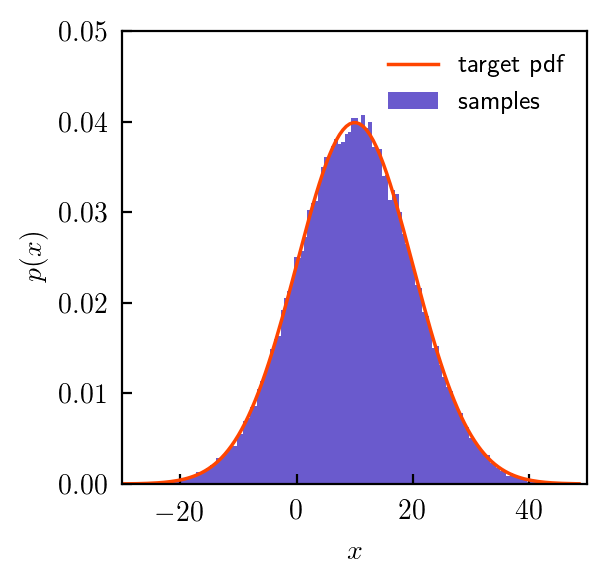

In [84]:
g = np.random.normal(size=nr)
plot_pdf(g1, func=gaussian_pdf, args=[mu, sigma], xlims=[-30,50],
         ylims=[1.e-6,0.05], ylog=False, 
         bins='auto', xlabel=r'$x$', ylabel=r'$p(x)$', figsize=3)

Using Gaussian samples you can also create samples of some other distributions, such as $\chi^2$ and Student $t$ distribution.

When a large number of samples is needed and computational time is an issue, there is a more efficient <a href="https://en.wikipedia.org/wiki/Ziggurat_algorithm">*ziggurat algorithm*</a> of Marsaglia & Tang (2000) to sample symmetric unimodal distributions such as Gaussian and Student $t$. However, this algorithm won't work for assymetric distributions such as $\chi^2$.  

## <font color='blue'>Generating correlated random samples (optional for undergraduate students)</font>

In practical applications one often needs to generate correlated random numbers reflecting correlations in the underlying model. 

Suppose we have a sequence of $N$ ($N\geq 2$) *uncorrelated* random numbers with zero mean and unit variance, $\vec{x}=\{x_i\}$, $\langle \vec{x}\rangle=0$ and $\langle\vec{x}\cdot\vec{x}^T\rangle = I,$
where $I$ is a unitary matrix and angle brackets denote averaging. 

We want to generate a sequence of $N$ correlated random numbers, $\vec{y}=\{y_i\}$, with correlations given by *covariance matrix*, $C\equiv \langle \vec{y}\cdot\vec{y}^T\rangle$, with elements 
\begin{equation}
C_{ij}=\frac{1}{N_s-1}\sum\limits_{k=1}^{N_s}(y_{ik}-\langle{y}_i\rangle)(y_{jk}-\langle{y}_j\rangle),
\end{equation}
where averaging is done over some number $N_s$ of sample realizations of $\vec{y}$.

Thus, given a vector of uncorrelated random numbers $\vec{x}$ to generate a vector of random samples $\vec{y}$ correlated among each other with correlations given by the covariance matrix $C$, we need to find a transformation matrix $M$ that satisfies the following two equations:
\begin{equation}
\vec{y}=M\cdot \vec{x},\ \ \ C=\langle\vec{y}\cdot\vec{y}^T\rangle.
\end{equation}

Substituting the left equation into the right one and taking into account that $\vec{x}$ has unit variance, we have:
\begin{equation}
C=\langle M\cdot \vec{x}\cdot\vec{x}^T\cdot M^T\rangle = M\cdot\langle\vec{x}\cdot\vec{x}^T\rangle\cdot M^T=M\cdot M^T.
\end{equation}

In other words, $M$ is the result of a decomposition of $C$ into a product of a matrix and its transpose. 

### <font color='blue'>Computing $M$ using Cholesky decomposition</font>

For a covariance matrix that is by its definition symmetric and positive-definite, the most efficient way to achieve this is to use the *Cholesky decomposition*: $C=L\cdot L^T$, where  $L$ is the lower triangular matrix. 

So the matrix $M$ we are seeking is the lower rectangular matrix resulting from the Cholesky decomposition of the covariance matrix $C$.
Standard linear algebra libraries always include a Cholesky decomposition function (e.g., <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html"><tt>numpy.linalg.cholesky</tt></a> in numpy).

The required correlated numbers drawn from the same distribution as $\{x_i\}$ but which have the required covariance matrix and mean $\langle\vec{y}\rangle$ are then given by 
\begin{equation}
\vec{y}=\langle\vec{y}\rangle + L\cdot\vec{x},\ \ \ \mathrm{or}\ \ \ \ y_i=\langle y_i\rangle + \sum\limits_{j=1}^N L_{ij} x_j.
\end{equation}

### <font color='blue'>Importance sampling (optional for everyone)</font>

Often we are interested not in the samples from a given distribution $p(x)$ themselves, but rather in averages of various quantities over that distribution. For example, average of function $g(x)$ over $p(x)$ distribution:

$$
\bar{g}_{p} = \int\limits_a^{b}g(x)p(x)dx \approx \frac{1}{N_s}\sum\limits_{i=1}^{N_s} g(x_{i,p}),\ \ \mathrm{where}\ \ x_{i,p}\sim p(x),
$$
where the last part indicates that $x_{i,p}$ are samples drawn from $p(x)$.

If this is the case and $p(x)$ is a distribution that's difficult to sample from, we can choose a function, $q(x)$, called the *importance* function, that's easy to sample from, and re-write the expression for $\bar{g}_p$ as

$$
\bar{g}_{p} = \int\limits_a^{b}g(x)\,\frac{p(x)}{q(x)}\, q(x)dx \approx \frac{1}{N_s}\sum\limits_{i=1}^{N_s} g(x_{i,q})\,\frac{p(x_{i,q})}{q(x_{i,q})},\ \ \mathrm{where}\ \ x_{i,q}\sim q(x).
$$

Thus, we can get an estimate of an average (or any other moment) over a given distribution, by sampling from a different distribution. Note that for numerical stability reasons, $p/q$ ratio should never be overly large. Thus $q(x)$ is chosen in such a way that $p(x)/q(x)$ goes to zero or varies mildly as $p(x)$ goes to zero. 

The importance sampling is useful not only because it allows to compute averages over distribution by sampling an easier to sample distribution, but also because
such averages can be more accurate than the straightforward average over $p(x)$. This is because sampling from $q(x)$ can concentrate the samples into *important* regions that contribute the most to the integral. 

## <font color='blue'>Rejection sampling (optional for everyone)</blue>

If the maximum, $p_{\rm max}$, of the pdf $p(x)$ in the interval $x\in [a, b]$ is known, the random samples of $p(x)$ can be generated by 

1. Drawing two random numbers $x$ and $y$ uniformly distributed in the intervals $[a,b]$ and $[0,p_{\rm max}]$, respectively. 

2. Accepting $x$ as a sample of $p(x)$ with probability $p(x)$: that is, if $p(x)\geq y$, or rejecting the draw otherwise and going back to step 1.  

Steps 1 and 2 are repeated until the number of accepted samples of $x$ reaches a desired value.

### <font color='blue'>Rejection sampling: geometric interpretation</blue>

The logic of this method is best grasped visually: we are throwing "darts" into random locations in the $(x,y)$ plane and accept only those locations that fall under the curve $p(x)$. The fraction of draws accepted in a given interval $dx$ is given by $p(x)$ by construction and result of the rejection sampling will clearly be the set of $x$ that have distribution $p(x)$.  

### <font color='blue'>An exercise to practice rejection method of generating random samples</font>

Write a code that generates random samples $\{x_i\}$ from the exponential pdf 
$p_{\rm exp}(x) = \exp(-\beta x)\beta$ defined for $x\in [0,\infty)$ (and $p_{\rm exp}(x)=0$ for $x<0$) using rejection sampling. Generate numbers for a fixed number of tries (say 100000). Output both the sampled numbers and the fraction of accepted draws during rejection sampling process.

Test it for some values of $\beta$ (e.g., $\beta=3$), using an input 
vector of uniformly distributed numbers.

In [104]:
nrnd = 100000
xmin, xmax = 0, 30
# generate a vector of nrnd uniformly distributed numbers over [xmin,xmax]
xrnd = np.random.uniform(xmin, xmax, nrnd)

In [105]:
# max values on the interval [0,30.] is exp(-0/beta)*beta = beta, so:
beta = 3.
yrnd = np.random.uniform(0.,beta, nrnd)

# numpy allows as to draw samples from xrnd by using the following compact ode
yexp = xrnd[(yrnd < exp_pdf(xrnd,beta))]

print("selected sample of %d exponentially distributed numbers out of %d"%(np.size(yexp), Nrnd))


selected sample of 1054 exponentially distributed numbers out of 100000


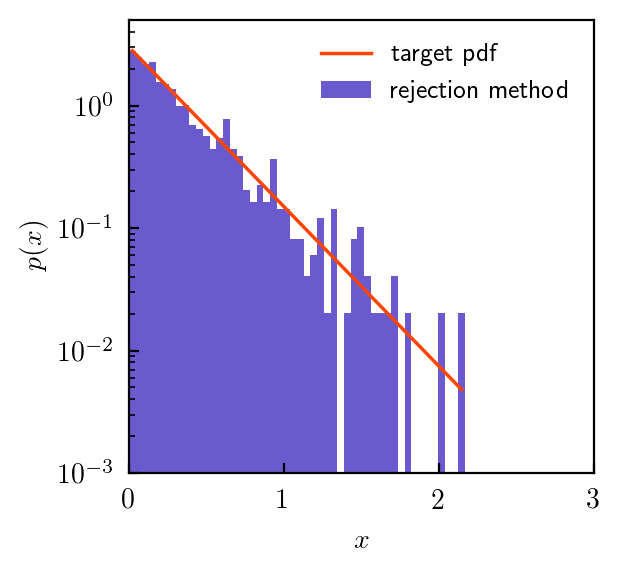

In [103]:
plot_pdf(yexp, func=exp_pdf, label='rejection method', args=[beta,], 
         xlims=[0,3], ylims=[1.e-3,5], figsize=3)

We can see that close to 90% of the generated samples are rejected. This is because they fall into the white area above the $p(x)$ curve, which is quite large. So the method in this basic form is inefficient for functions that change fast and over a wide range like $e^{-\xi/\beta}$ used here. 

### <font color='blue'>Improving efficiency of the rejection method</blue>

Yes.  Efficiency can be improved with a variant of the method, in which samples from another pdf, $q(x)$, are used. Function $q(x)$ should be 
a function that is easy to sample with the inverse transform method or any other method. Also, we should have $p(x)<mq(x)$ for all $x\in[a,b]$, where $m$ is some constant.

The algorithm consists of the following steps: 

1. Generate a random sample $x_q$ from $q(x)$.

2. Draw a random number uniformly distributed in $[0,1)$: $u\sim u_{[0,1)}$; 

3. Accept the draw $x_q$ as a sample of $p(x)$, if $u\leq p(x_q)/[m q(x_q)]$. 

Here for illustration I use $q(x)=e^{-x/\beta_2}/\beta_2$, where $\beta_2>\beta$ and $m=c \beta_2/\beta$, where $c$ is a constant just above $1.$ ensures that $mq(c)>p(x)$ everywhere. 


In [109]:
nr = 20000 # number of random numbers to generate
# non-vectorized version
i = 0 
yexp = []

# we will use an exponential with a slower rate of decrease
# as q(x)
beta2 = 1.01*beta 
m = 1.1*beta2/beta

itr = 0
while i < nr:
    itr += 1
    xd = np.random.uniform(0., 1.,size=1)
    xr = invcdf_exp(xd, beta2)
    yd = np.random.uniform(0., 1.0)
    if yd <= pdf_exp(xr,beta)/(m*pdf_exp(xr,beta2)):
        yexp.append(xr)
        i += 1
     
yexp = np.ravel(yexp)
print("selected sample of %d exponentially distributed numbers out of %d"%(np.size(yexp), itr))

selected sample of 20000 exponentially distributed numbers out of 22197


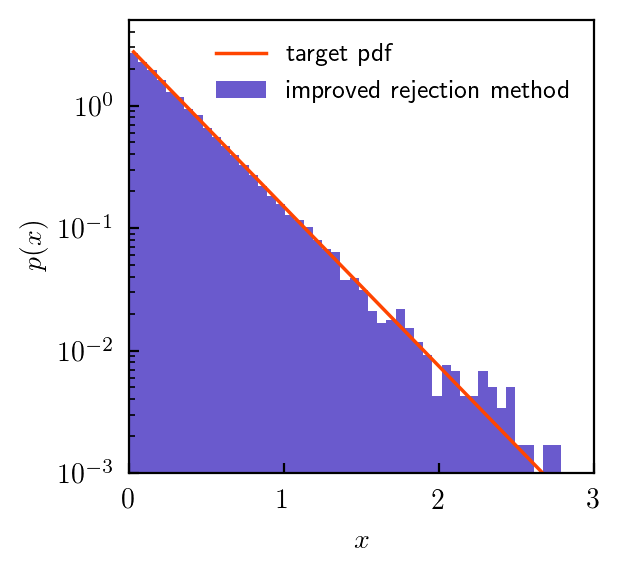

In [108]:
plot_pdf(yexp, func=exp_pdf, label='improved rejection method', args=[beta,], 
         xlims=[0,3], ylims=[1.e-3,5], figsize=3)

In [111]:
nr = 100000

#a vectorized (numpy) version without loops
beta2 = 1.01*beta # exponential with a slower rate of decrease
m = 1.01*beta2/beta # a factor to make sure that M*g(x) > f(x) everywhere

xrnd = np.random.uniform(0., 1., nr)
xd = invcdf_exp(xrnd, beta2)
yrnd = np.random.uniform(0., 1., nr)
yexp = xd[(yrnd <= pdf_exp(xd, beta)/(m * pdf_exp(xd, beta2)))] 

print("selected sample of %d exponentially distributed numbers out of %d"%(np.size(yexp), Nrnd))


selected sample of 97926 exponentially distributed numbers out of 100000


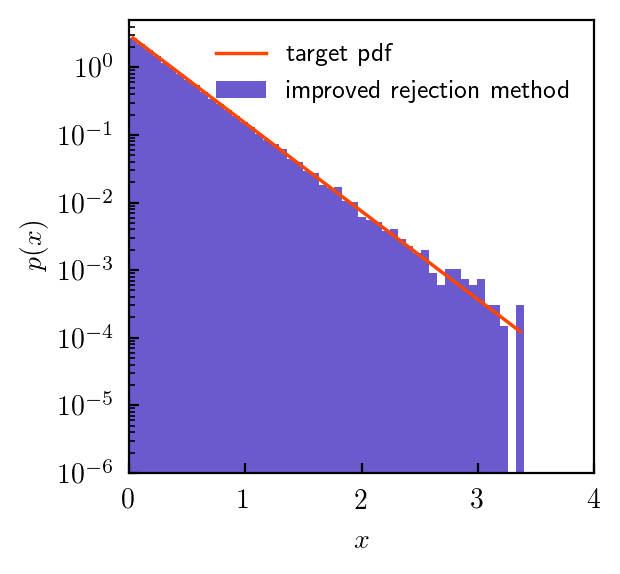

In [116]:
plot_pdf(yexp, func=exp_pdf, label='improved rejection method', args=[beta,], 
         xlims=[0,4], ylims=[1.e-6,5], figsize=3)